In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import os
import timm
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define basic transforms (just for inspection — no augmentation yet)
inspect_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to standard size
    transforms.ToTensor(),              # Convert to tensor (0-1 range)
])

# Load Training and Testing datasets
train_dataset = ImageFolder(root='data/Training', transform=inspect_transform)
test_dataset = ImageFolder(root='data/Testing', transform=inspect_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class indices: {train_dataset.class_to_idx}")

Training samples: 5712
Testing samples: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


**Inspect Class Distribution**

            Train  Test
notumor      1595   405
pituitary    1457   300
meningioma   1339   306
glioma       1321   300


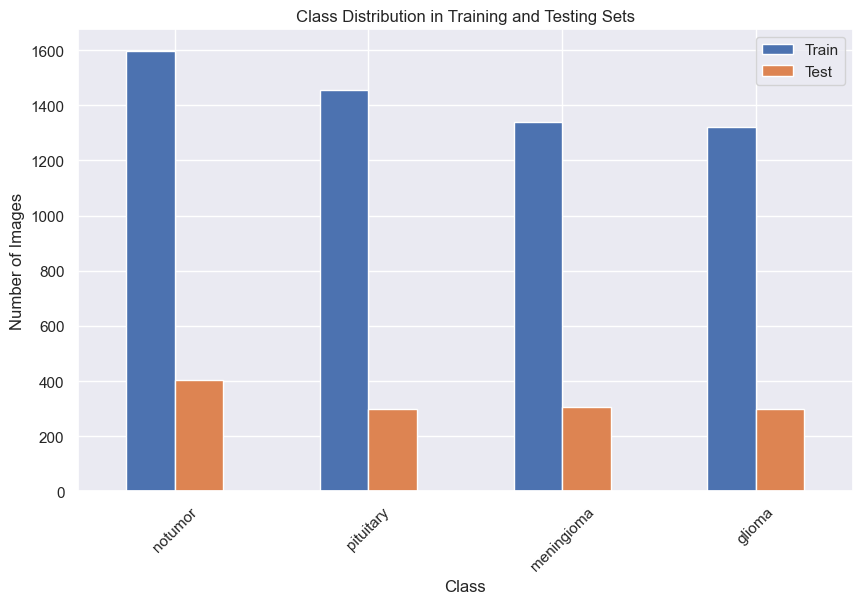

In [4]:
# Count images per class in train and test
train_counts = pd.Series(train_dataset.targets).value_counts().sort_index()
test_counts  = pd.Series(test_dataset.targets).value_counts().sort_index()

# Map indices to class names
train_counts.index = train_dataset.classes
test_counts.index  = test_dataset.classes

# Create a nice DataFrame
df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).sort_values(by='Train', ascending=False)
print(df)

# Plot distribution
df.plot(kind='bar', figsize=(10, 6))
plt.title('Class Distribution in Training and Testing Sets')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()

**Visualize Sample Images**

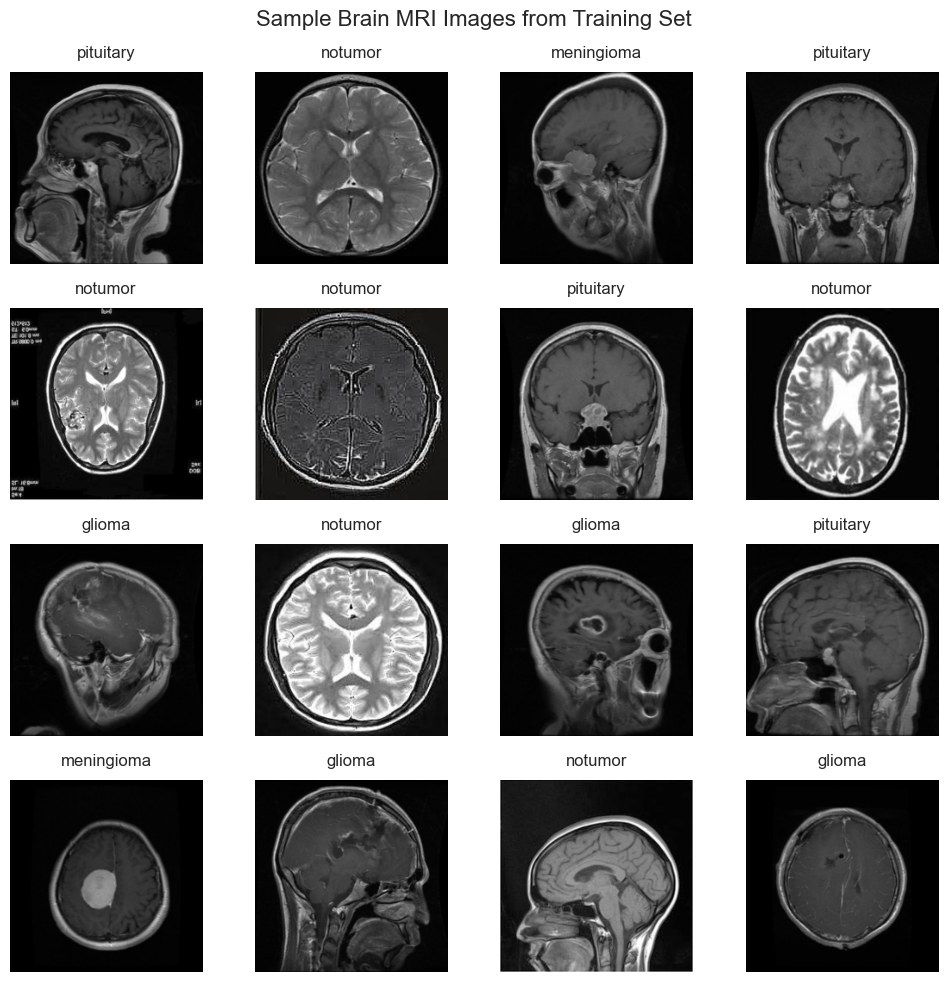

In [5]:

# Create a 4x4 grid of sample images with their correct labels
figure = plt.figure(figsize=(10, 10))  # Slightly larger for better visibility
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # Randomly pick an image from the training set
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    # Add subplot
    ax = figure.add_subplot(rows, cols, i)
    plt.axis("off")
    
    # Convert tensor to numpy and fix channel order: (C, H, W) -> (H, W, C)
    img_np = img.numpy().transpose((1, 2, 0))
    
    # Clip to [0, 1] (important since ToTensor() outputs 0-1)
    img_valid = np.clip(img_np, 0, 1)
    
    # Display image
    plt.imshow(img_valid)
    
    # Add the correct class label as title
    plt.title(train_dataset.classes[label], fontsize=12, pad=10)

# Main title for the whole figure
figure.suptitle('Sample Brain MRI Images from Training Set', fontsize=16, y=0.98)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**Image Augmentation**

In [6]:
# Training Transformation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15), 
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), 
    transforms.ToTensor(), # Converted to tensor first
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
])

# Testing Transformation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Matched to training size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
])

In [7]:
# Define an object of the custom dataset for the train and validation.
train_dataset = ImageFolder(root='data/Training', transform=train_transform)
test_dataset  = ImageFolder(root='data/Testing',  transform=test_transform)

**DataLoaders**

In [8]:
BATCH_SIZE = 16  # Reduced from 32 to save RAM

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   # Set to 0 to prevent multiprocessing crashes on CPU
    pin_memory=False # Usually better to keep False when training strictly on CPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches:  {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total training images: {len(train_loader.dataset)}")
print(f"Total testing images:  {len(test_loader.dataset)}")

Training batches: 357
Testing batches:  82
Batch size: 16
Total training images: 5712
Total testing images:  1311


In [9]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": test_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16]) torch.int64

Validation data:
Shape of X : torch.Size([16, 3, 224, 224])
Shape of y: torch.Size([16]) torch.int64



**Model Architecture**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create pretrained EfficientNet-B0 (excellent balance of speed/accuracy)
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=4)  
model = model.to(device)

### Model Architecture Summary 
summary(model, input_size=(1, 3, 224, 224))

# Alternative: ResNet50 if you prefer torchvision
# from torchvision import models
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 4)


Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [1, 4]                    --
├─Conv2d: 1-1                                 [1, 32, 112, 112]         864
├─BatchNormAct2d: 1-2                         [1, 32, 112, 112]         64
│    └─Identity: 2-1                          [1, 32, 112, 112]         --
│    └─SiLU: 2-2                              [1, 32, 112, 112]         --
├─Sequential: 1-3                             [1, 320, 7, 7]            --
│    └─Sequential: 2-3                        [1, 16, 112, 112]         --
│    │    └─DepthwiseSeparableConv: 3-1       [1, 16, 112, 112]         1,448
│    └─Sequential: 2-4                        [1, 24, 56, 56]           --
│    │    └─InvertedResidual: 3-2             [1, 24, 56, 56]           6,004
│    │    └─InvertedResidual: 3-3             [1, 24, 56, 56]           10,710
│    └─Sequential: 2-5                        [1, 40, 28, 28]           --
│    │   

**Loss function**

In [11]:
criterion = nn.CrossEntropyLoss()

**+ Optimizer + Scheduler**

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Scheduler: Set mode to 'min' if monitoring Loss, or 'max' if monitoring Accuracy
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

**Training and Validation Function**

In [13]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

**Training Process**

In [14]:
NUM_EPOCHS = 15
best_acc = 0.0

print("Training started!\n")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, test_loader, criterion, device)
    
    scheduler.step(val_loss)  # Pass validation loss (since mode='min')
    
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_brain_tumor_model.pth')
        print("   >>> Best model saved!\n")
    else:
        print("")

print(f"\nTraining finished! Best validation accuracy: {best_acc:.2f}%")

Training started!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 1/15
Train Loss: 0.5283 | Train Acc: 87.69%
Val   Loss: 0.1978 | Val   Acc: 95.50%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/15
Train Loss: 0.1634 | Train Acc: 94.73%
Val   Loss: 0.1081 | Val   Acc: 96.03%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/15
Train Loss: 0.1123 | Train Acc: 96.29%
Val   Loss: 0.0538 | Val   Acc: 98.02%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 4/15
Train Loss: 0.1207 | Train Acc: 96.10%
Val   Loss: 0.0542 | Val   Acc: 98.32%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 5/15
Train Loss: 0.0769 | Train Acc: 97.23%
Val   Loss: 0.0970 | Val   Acc: 96.64%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 6/15
Train Loss: 0.0952 | Train Acc: 96.62%
Val   Loss: 0.0863 | Val   Acc: 97.18%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 7/15
Train Loss: 0.0369 | Train Acc: 98.65%
Val   Loss: 0.0154 | Val   Acc: 99.47%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 8/15
Train Loss: 0.0205 | Train Acc: 99.40%
Val   Loss: 0.0132 | Val   Acc: 99.69%
   >>> Best model saved!



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 9/15
Train Loss: 0.0219 | Train Acc: 99.35%
Val   Loss: 0.0423 | Val   Acc: 98.93%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 10/15
Train Loss: 0.0174 | Train Acc: 99.47%
Val   Loss: 0.0295 | Val   Acc: 98.78%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 11/15
Train Loss: 0.0403 | Train Acc: 98.77%
Val   Loss: 0.0486 | Val   Acc: 98.86%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 12/15
Train Loss: 0.0178 | Train Acc: 99.33%
Val   Loss: 0.0124 | Val   Acc: 99.62%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 13/15
Train Loss: 0.0099 | Train Acc: 99.60%
Val   Loss: 0.0121 | Val   Acc: 99.31%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 14/15
Train Loss: 0.0077 | Train Acc: 99.81%
Val   Loss: 0.0104 | Val   Acc: 99.62%



Training:   0%|          | 0/357 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 15/15
Train Loss: 0.0094 | Train Acc: 99.74%
Val   Loss: 0.0216 | Val   Acc: 99.47%


Training finished! Best validation accuracy: 99.69%


**Classification Report and Confusion Matrix Code**

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



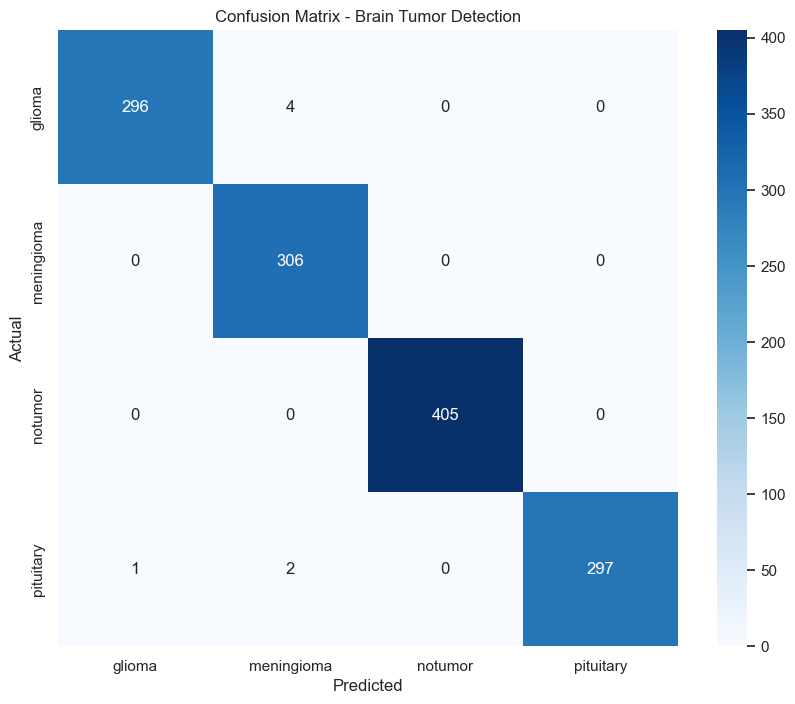

In [15]:
def evaluate_final_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Get class names from the dataset
    class_names = loader.dataset.classes
    
    # 1. Print Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 2. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Brain Tumor Detection')
    plt.show()

# Run evaluation on your test_loader
evaluate_final_model(model, test_loader, device)

**Metric Evaluation Visualiazation**

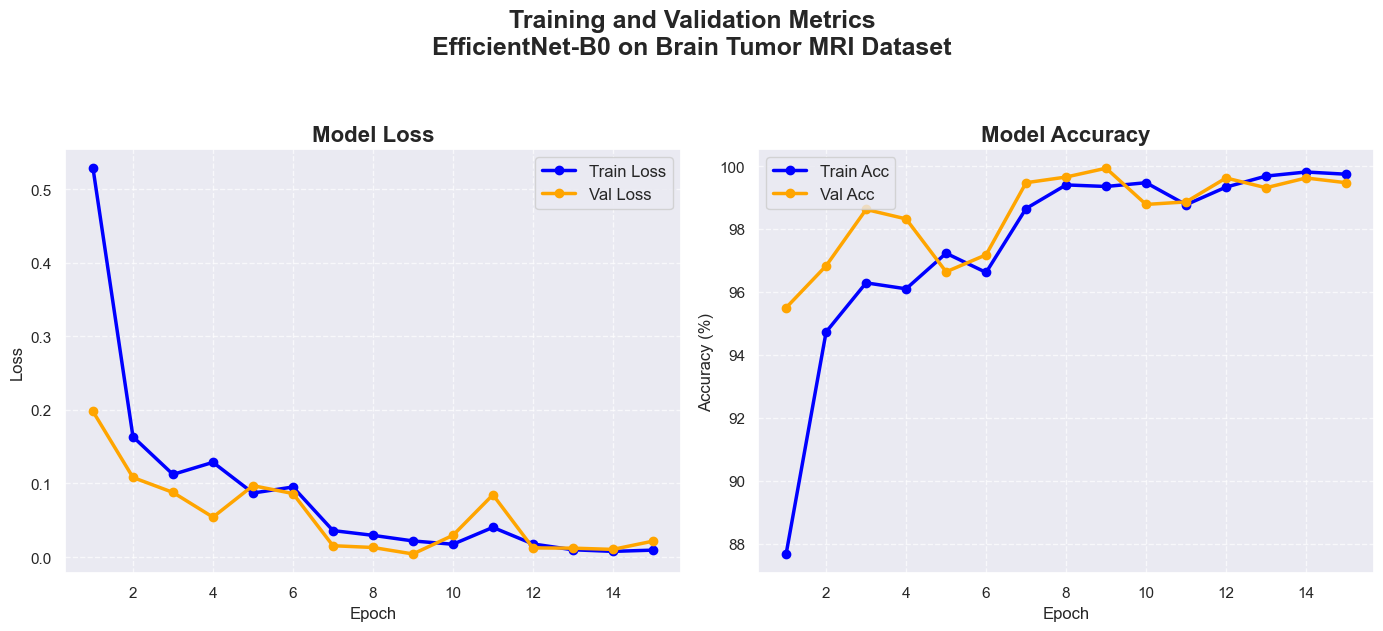

In [25]:
import matplotlib.pyplot as plt

epochs = list(range(1, 16))  # 1 to 15

# I forgot to store the proces or history in a list , so i put it manually
train_losses = [0.5283, 0.1634, 0.1123, 0.1287, 0.0870, 0.0952, 0.0360, 0.0295, 
                0.0219, 0.0174, 0.0403, 0.0178, 0.0099, 0.0077, 0.0094]

train_accs = [87.68, 94.73, 96.29, 96.10, 97.23, 96.62, 98.65, 99.40, 
              99.35, 99.47, 98.77, 99.33, 99.68, 99.81, 99.74]

val_losses = [0.1978, 0.1081, 0.0878, 0.0542, 0.0970, 0.0863, 0.0154, 0.0130, 
              0.0042, 0.0295, 0.0846, 0.0124, 0.0121, 0.0104, 0.0216]

val_accs = [95.50, 96.83, 98.62, 98.32, 96.64, 97.18, 99.47, 99.65, 
            99.93, 98.78, 98.86, 99.62, 99.31, 99.62, 99.47]

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Loss plot
ax1.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2.5, marker='o')
ax1.plot(epochs, val_losses, label='Val Loss', color='orange', linewidth=2.5, marker='o')
ax1.set_title('Model Loss', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Accuracy plot
ax2.plot(epochs, train_accs, label='Train Acc', color='blue', linewidth=2.5, marker='o')
ax2.plot(epochs, val_accs, label='Val Acc', color='orange', linewidth=2.5, marker='o')
ax2.set_title('Model Accuracy', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Overall title
fig.suptitle('Training and Validation Metrics\nEfficientNet-B0 on Brain Tumor MRI Dataset', 
             fontsize=18, fontweight='bold', y=1.05)

plt.tight_layout()
plt.show()

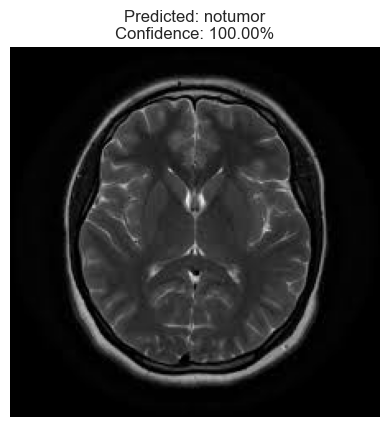

('notumor', 100.0)

In [33]:
from PIL import Image
import torchvision.transforms as transforms

def predict_image(image_path, model, device):
    model.eval()
    
    img = Image.open(image_path).convert('RGB')
    
    #same transform as test (no augmentation)
    img = test_transform(img).unsqueeze(0).to(device)  # Add batch dim
    
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
        prob = torch.softmax(output, dim=1)[0] * 100
    
    predicted_class = class_names[pred.item()]
    confidence = prob[pred.item()].item()
    
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

# Example usage:
#predict_image('path/to/your/single_mri.jpg', model, device)
predict_image(r'C:\Users\LUCAS\Desktop\normal_text.jpg', model, device)

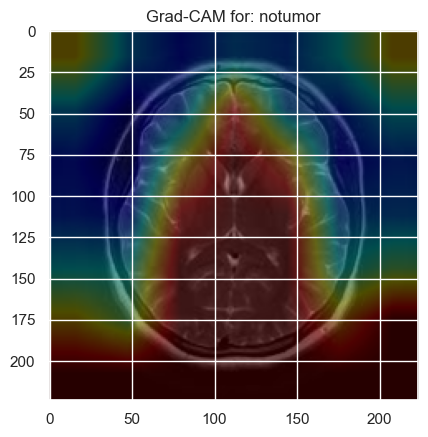

In [ ]:
import numpy as np
import cv2
from PIL import Image

# 1. Setup: Target the last convolutional layer of EfficientNet-B0
# For timm EfficientNet-B0, this is usually 'conv_head' or 'act2'
target_layer = model.conv_head 

# Dictionary to store gradients and activations
gradients = {}
activations = {}

def get_gradients(module, grad_input, grad_output):
    gradients['value'] = grad_output[0]

def get_activations(module, input, output):
    activations['value'] = output

# Register hooks to capture data during the forward/backward pass
target_layer.register_forward_hook(get_activations)
target_layer.register_full_backward_hook(get_gradients)

def generate_gradcam(image_path, model, transform):
    # Prepare image
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    # Forward pass
    model.eval()
    output = model(input_tensor)
    _, pred_idx = torch.max(output, 1)
    
    # Backward pass for the predicted class
    model.zero_grad()
    output[0, pred_idx].backward()
    
    # Process Grad-CAM
    grads = gradients['value'].cpu().data.numpy()[0]
    target = activations['value'].cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    
    cam = np.zeros(target.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * target[i, :, :]
    
    # Heatmap post-processing
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    # Superimpose heatmap on original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_array = np.array(img.resize((224, 224)))
    result = heatmap * 0.3 + img_array * 0.5
    
    return result, class_names[pred_idx.item()]

# Execute
cam_image, prediction = generate_gradcam(r'C:\Users\LUCAS\Desktop\normal_text.jpg', model, test_transform)
plt.imshow(cam_image.astype(int))
plt.title(f"Grad-CAM for: {prediction}")
plt.show()